In [1]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install -U seaborn

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import evaluate
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from collections import defaultdict

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
DATASET_DIR = 'data/full_maven_with_category.csv'

## Load Dataset

In [4]:
def load_dataset(file_location, target_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_location)
    labels = sorted(list(df[target_column].unique()))
    print(len(labels))

    #convert labels in target column to numbers
    df[target_column] = df[target_column].apply(lambda x: labels.index(x))

    return df, labels

In [5]:
data_df, label_list = load_dataset(DATASET_DIR, LABEL_COLUMN)
train_data, test_data, train_labels, test_labels = train_test_split(data_df, data_df[LABEL_COLUMN], test_size=VAL_RATIO, random_state=42)

15


In [6]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,Battle of Salis,3,15,"[('Battle', 'of'), ('of', 'Salis')]","['battle', 'of', 'Salis']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'salis': 0.008540730727941325}","['battle', 'salis']",9
1,Battle of Sudoměř,3,17,"[('Battle', 'of'), ('of', 'Sudoměř')]","['battle', 'of', 'Sudoměř']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART']","{'battle': 1.0, 'sudoměř': 0.008540730727941325}","['battle', 'sudoměř']",9
2,Texxas Jam,2,10,"[('Texxas', 'Jam')]","['Texxas', 'Jam']","['PROPN', 'PROPN']","['NNP', 'NNP']","['compound', 'ROOT']","['PERSON', 'PERSON']","{'texxas': 0.2043111942133731, 'jam': 1.0}","['texxas', 'jam']",0
3,Territorial era of Minnesota,4,28,"[('Territorial', 'era'), ('era', 'of'), ('of',...","['territorial', 'era', 'of', 'Minnesota']","['ADJ', 'NOUN', 'ADP', 'PROPN']","['JJ', 'NN', 'IN', 'NNP']","['amod', 'ROOT', 'prep', 'pobj']","['', '', '', 'GPE']","{'territorial': 0.4708947929883977, 'era': 0.4...","['territorial', 'era', 'minnesota']",12
4,Death of Joy Gardner,4,20,"[('Death', 'of'), ('of', 'Joy'), ('Joy', 'Gard...","['death', 'of', 'Joy', 'Gardner']","['NOUN', 'ADP', 'PROPN', 'PROPN']","['NN', 'IN', 'NNP', 'NNP']","['ROOT', 'prep', 'compound', 'pobj']","['', '', 'PERSON', 'PERSON']","{'death': 1.0, 'joy': 0.11603765993719264, 'ga...","['death', 'joy', 'gardner']",1


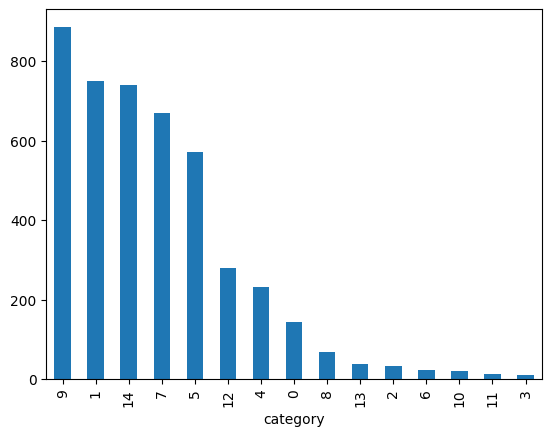

In [7]:
def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [8]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 15
Shape of the training data:  (3131, 12)
Shape of the test data:  (1343, 12)


In [9]:
model_checkpoint = "roberta-base"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [10]:
from datasets import Dataset

def preprocess_function(input_data):
    # Extract features from input_data
    titles = input_data['title'].tolist()
    word_count = input_data['word_count'].tolist()
    character_count = input_data['character_count'].tolist()
    bigrams = input_data['bigrams'].tolist()
    lemma = input_data['lemma'].tolist()
    pos = input_data['pos'].tolist()
    tag = input_data['tag'].tolist()
    dep = input_data['dep'].tolist()
    context_score = input_data['context_score'].tolist()
    trigger_words = input_data['trigger_words'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Create a Dataset object
    dataset = Dataset.from_dict({
        'text': titles,
        'label': input_data[LABEL_COLUMN].tolist(),  # Assuming the label column name is LABEL_COLUMN
        'word_count': word_count,
        'character_count': character_count,
        'bigrams': bigrams,
        'lemma': lemma,
        'pos': pos,
        'tag': tag,
        'dep': dep,
        'context_score': context_score,
        'trigger_words': trigger_words,
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    })

    return dataset

In [11]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
encoded_train

Dataset({
    features: ['text', 'label', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'context_score', 'trigger_words', 'input_ids', 'attention_mask'],
    num_rows: 3131
})

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50265, 768, padding_idx=1)

In [13]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [14]:
# Create the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=3e-5)

# Define the number of training steps and warmup steps
num_train_steps = len(encoded_train) * 20
num_warmup_steps = int(0.1 * num_train_steps)  # 10% of total steps

# Create the linear scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,2.660823,0.140730
2,No log,1.999487,0.395383
3,2.378500,1.282122,0.682055
4,2.378500,0.967459,0.731943
5,2.378500,0.802450,0.793745
6,1.091800,0.710455,0.819062
7,1.091800,0.645711,0.840655
8,0.591200,0.649556,0.842144
9,0.591200,0.662263,0.837677
10,0.591200,0.632967,0.850335


TrainOutput(global_step=3920, training_loss=0.6434392598210549, metrics={'train_runtime': 631.1705, 'train_samples_per_second': 99.212, 'train_steps_per_second': 6.211, 'total_flos': 643669429528800.0, 'train_loss': 0.6434392598210549, 'epoch': 20.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.8361967206001282,
 'eval_f1': 0.8801191362620998,
 'eval_runtime': 1.147,
 'eval_samples_per_second': 1170.911,
 'eval_steps_per_second': 73.236,
 'epoch': 20.0}

In [19]:
bert_eval = trainer.evaluate(encoded_test)
bert_eval

{'eval_loss': 0.8361967206001282,
 'eval_f1': 0.8801191362620998,
 'eval_runtime': 1.3253,
 'eval_samples_per_second': 1013.327,
 'eval_steps_per_second': 63.38,
 'epoch': 20.0}

In [20]:
predictions = trainer.predict(encoded_test)

Accuracy: 0.8801191362620998
Precision: 0.8811221515987209
Recall: 0.8801191362620998
F1: 0.8785030017451796


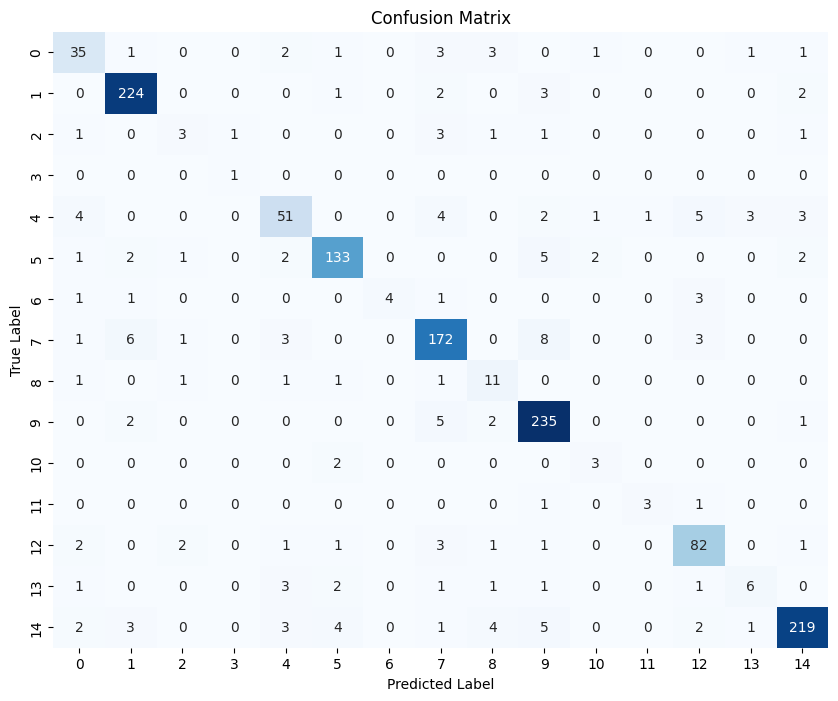

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
ground_truth_labels = encoded_test["label"]
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(y_true=ground_truth_labels, y_pred=predicted_labels)
precision = precision_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
recall = recall_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
f1 = f1_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
confusion_matrix = confusion_matrix(ground_truth_labels, predicted_labels)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()